In [33]:
# 讀取Kaggle上的資料集到Colab
!pip install kaggle
from google.colab import files
files.upload()    #上傳kaggle token

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"hauhsiunglee","key":"b0fac84ff4be293eddc8d4d3f6973c1a"}'}

In [34]:
#建立一個資料夾把token放入，並給予其權限
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d dgomonov/new-york-city-airbnb-open-data
! unzip new-york-city-airbnb-open-data.zip

new-york-city-airbnb-open-data.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  new-york-city-airbnb-open-data.zip
replace AB_NYC_2019.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: AB_NYC_2019.csv         
replace New_York_City_.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: New_York_City_.png      


In [36]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold

In [37]:
ny_ab = pd.read_csv('AB_NYC_2019.csv')
ny_ab.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [ ]:
print('Number of features: {}'.format(ny_ab.shape[1]))
print('Number of examples: {}'.format(ny_ab.shape[0]))

Number of features: 16
Number of examples: 48895


In [38]:
#資料前處理
ny_ab.drop(['host_name','name','latitude','longitude','last_review','id','host_id'], axis=1, inplace=True) #不需要的欄位丟棄
ny_ab['reviews_per_month'] = ny_ab['reviews_per_month'].fillna(0) #填補遺漏值
ny_ab.head()

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,Private room,150,3,0,0.00,1,365
3,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,Entire home/apt,80,10,9,0.10,1,0


In [39]:
#根據類別變數欄位，新增虛擬變數欄位
#透過One-Hot Encoding
categorical_features = ny_ab.select_dtypes(include=['object'])
categorical_features_one_hot = pd.get_dummies(categorical_features)
categorical_features_one_hot.head()

,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_Allerton,neighbourhood_Arden Heights,neighbourhood_Arrochar,neighbourhood_Arverne,neighbourhood_Astoria,neighbourhood_Bath Beach,neighbourhood_Battery Park City,neighbourhood_Bay Ridge,neighbourhood_Bay Terrace,"neighbourhood_Bay Terrace, Staten Island",neighbourhood_Baychester,neighbourhood_Bayside,neighbourhood_Bayswater,neighbourhood_Bedford-Stuyvesant,neighbourhood_Belle Harbor,neighbourhood_Bellerose,neighbourhood_Belmont,neighbourhood_Bensonhurst,neighbourhood_Bergen Beach,neighbourhood_Boerum Hill,neighbourhood_Borough Park,neighbourhood_Breezy Point,neighbourhood_Briarwood,neighbourhood_Brighton Beach,neighbourhood_Bronxdale,neighbourhood_Brooklyn Heights,neighbourhood_Brownsville,neighbourhood_Bull's Head,neighbourhood_Bushwick,neighbourhood_Cambria Heights,neighbourhood_Canarsie,neighbourhood_Carroll Gardens,neighbourhood_Castle Hill,neighbourhood_Castleton Corners,neighbourhood_Chelsea,...,neighbourhood_Spuyten Duyvil,neighbourhood_St. Albans,neighbourhood_St. George,neighbourhood_Stapleton,neighbourhood_Stuyvesant Town,neighbourhood_Sunnyside,neighbourhood_Sunset Park,neighbourhood_Theater District,neighbourhood_Throgs Neck,neighbourhood_Todt Hill,neighbourhood_Tompkinsville,neighbourhood_Tottenville,neighbourhood_Tremont,neighbourhood_Tribeca,neighbourhood_Two Bridges,neighbourhood_Unionport,neighbourhood_University Heights,neighbourhood_Upper East Side,neighbourhood_Upper West Side,neighbourhood_Van Nest,neighbourhood_Vinegar Hill,neighbourhood_Wakefield,neighbourhood_Washington Heights,neighbourhood_West Brighton,neighbourhood_West Farms,neighbourhood_West Village,neighbourhood_Westchester Square,neighbourhood_Westerleigh,neighbourhood_Whitestone,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [40]:
ny_ab = pd.concat([ny_ab,categorical_features_one_hot], axis=1) #加上新增的虛擬變數欄位 
ny_ab.drop(categorical_features, axis=1, inplace=True)   #丟掉原本的類別變數欄位
ny_ab

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_Allerton,neighbourhood_Arden Heights,neighbourhood_Arrochar,neighbourhood_Arverne,neighbourhood_Astoria,neighbourhood_Bath Beach,neighbourhood_Battery Park City,neighbourhood_Bay Ridge,neighbourhood_Bay Terrace,"neighbourhood_Bay Terrace, Staten Island",neighbourhood_Baychester,neighbourhood_Bayside,neighbourhood_Bayswater,neighbourhood_Bedford-Stuyvesant,neighbourhood_Belle Harbor,neighbourhood_Bellerose,neighbourhood_Belmont,neighbourhood_Bensonhurst,neighbourhood_Bergen Beach,neighbourhood_Boerum Hill,neighbourhood_Borough Park,neighbourhood_Breezy Point,neighbourhood_Briarwood,neighbourhood_Brighton Beach,neighbourhood_Bronxdale,neighbourhood_Brooklyn Heights,neighbourhood_Brownsville,neighbourhood_Bull's Head,neighbourhood_Bushwick,...,neighbourhood_Spuyten Duyvil,neighbourhood_St. Albans,neighbourhood_St. George,neighbourhood_Stapleton,neighbourhood_Stuyvesant Town,neighbourhood_Sunnyside,neighbourhood_Sunset Park,neighbourhood_Theater District,neighbourhood_Throgs Neck,neighbourhood_Todt Hill,neighbourhood_Tompkinsville,neighbourhood_Tottenville,neighbourhood_Tremont,neighbourhood_Tribeca,neighbourhood_Two Bridges,neighbourhood_Unionport,neighbourhood_University Heights,neighbourhood_Upper East Side,neighbourhood_Upper West Side,neighbourhood_Van Nest,neighbourhood_Vinegar Hill,neighbourhood_Wakefield,neighbourhood_Washington Heights,neighbourhood_West Brighton,neighbourhood_West Farms,neighbourhood_West Village,neighbourhood_Westchester Square,neighbourhood_Westerleigh,neighbourhood_Whitestone,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,149,1,9,0.21,6,365,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,225,1,45,0.38,2,355,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,150,3,0,0.00,1,365,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,89,1,270,4.64,1,194,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,80,10,9,0.10,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,70,2,0,0.00,2,9,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
48891,40,4,0,0.00,2,36,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
48892,115,10,0,0.00,1,27,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
48893,55,1,0,0.00,6,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [41]:
#數值型資料標準化 
#跟價格相關的欄位
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(ny_ab[ny_ab.columns[ny_ab.columns.str.contains('price')==False]]) #標準化
ny_ab[ny_ab.columns[ny_ab.columns.str.contains('price')==False]] = x_scaled #替換原欄位

In [42]:
#區分 trining data 和 testing data
#這裡是最簡單的train_test_split方法，另外較複雜的常用方法是k-folds Cross Validation
#time series data則常用Rolling Validation
X_train, X_test, y_train, y_test = train_test_split(ny_ab[ny_ab.columns[ny_ab.columns.str.contains('price')==False]] , ny_ab['price'] , test_size=0.1, random_state=42)

In [ ]:
X_train #自變數的訓練集

In [ ]:
 X_test #對應x_train的測試集

In [ ]:
 y_train #應變數的訓練集

In [ ]:
 y_test #對應y_train的測試集

In [43]:
#定義模型

model = tf.keras.Sequential([
    tf.keras.layers.Dense(256,activation=tf.nn.relu),
    tf.keras.layers.Dense(128,activation=tf.nn.relu),
    tf.keras.layers.Dense(64,activation=tf.nn.relu),
    tf.keras.layers.Dense(32,activation=tf.nn.relu),
    tf.keras.layers.Dense(16,activation=tf.nn.relu),
    tf.keras.layers.Dense(1,activation=tf.nn.relu)
])

In [44]:
  model.compile(optimizer='adam',
                loss='mean_squared_error',
                metrics=['mean_squared_error'])

In [45]:
history = model.fit(X_train.values ,y_train.values, epochs=100, validation_split = 0.1)

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1238/1238 [==============================] - 3s 2ms/step - loss: 45383.6406 - mean_squared_error: 45383.6406 - val_loss: 108682.2109 - val_mean_squared_error: 108682.2109
Epoch 2/100
1238/1238 [==============================] - 3s 2ms/step - loss: 43996.7344 - mean_squared_error: 43996.7344 - val_loss: 108886.1641 - val_mean_squared_error: 108886.1641
Epoch 3/100
1238/1238 [==============================] - 3s 2ms/step - loss: 43782.0156 - mean_squared_error: 43782.0156 - val_loss: 108109.53

In [46]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_squared_error,val_loss,val_mean_squared_error,epoch
95,34372.429688,34372.429688,108844.406250,108844.406250,95
96,33113.964844,33113.964844,108742.539062,108742.539062,96
97,34562.968750,34562.968750,107325.875000,107325.875000,97
98,34341.777344,34341.777344,107790.781250,107790.781250,98
99,32343.955078,32343.955078,107304.234375,107304.234375,99


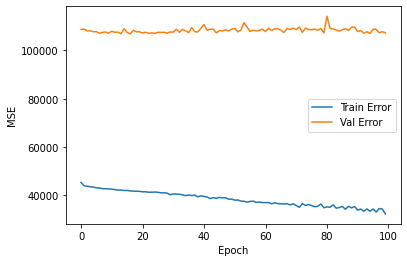

In [48]:
#繪圖觀察training data, testing data的loss

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.legend()


  plt.show()


plot_history(history)